In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely import affinity
from shapely.geometry import Point
from shapely.ops import unary_union

In [6]:
#NOTE TO REBEKAH: 
# this block is for prepping data from transit zip for the plotting

#the only things needed for *transit_agg* are the geo_id (for aggregating, you've basically done this already) 
# geometry (for plotting) and quality_score (for the colors)

#the only things needed for *neighborhood* are the neighborhood names and the geometries
#the block below the neighborhood plot is what assigns the "zone labels"

#i've included all work that's been done, feel free to extract the non-commented work as they're what's important.
#u can probs include the "raw" version near the end with all my work plus the functional parts of things

#NOTE there are some zones that aren't covered so they'll be labeled as none for now (as default) feel free to change

transit = gpd.read_file('data/transit.zip')
transit = transit.rename(columns={'csdname':'city', 'policy_yea':'year', 'transit_qu':'transit_quality'})
transit['log'] = np.log(transit['transit_quality'])

transit['quality_score'] = transit['log'] + 1
transit = transit[['geo_uid', 'city', 'year', 'quality_score', 'geometry']]
transit = transit[(transit['year'] == 2010) | (transit['year'] == 2015) | (transit['year'] == 2020)]
# transit.plot(column='geometry')
# transit = transit[transit['year'] == 2015]
transit

,geo_uid,city,year,quality_score,geometry
0,59150307,Vancouver,2010,2.829753,"POLYGON ((498310.190 5459815.920, 498309.638 5..."
1,59150308,Vancouver,2010,5.458190,"POLYGON ((498303.642 5459212.268, 498303.155 5..."
2,59150309,Vancouver,2010,5.832826,"POLYGON ((497940.841 5459213.445, 497940.812 5..."
3,59150310,Vancouver,2010,6.507989,"POLYGON ((498298.679 5458709.775, 498298.646 5..."
4,59150311,Vancouver,2010,6.012171,"POLYGON ((497939.463 5458606.665, 498128.359 5..."
...,...,...,...,...,...
5947,59153996,Vancouver,2020,8.492825,"POLYGON ((491123.035 5459615.245, 491120.710 5..."
5948,59153997,Vancouver,2020,8.506496,"POLYGON ((491676.840 5459587.193, 491605.386 5..."
5949,59154000,Vancouver,2020,7.909729,"POLYGON ((492570.830 5458268.003, 492570.838 5..."
5950,59154001,Vancouver,2020,8.931254,"POLYGON ((492175.437 5458706.854, 492275.116 5..."


Text(0.5, 1.0, "Map of Vancouver's Transit Quality")

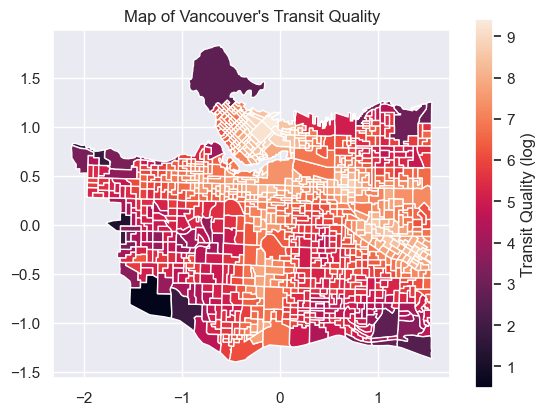

In [7]:
#neighborhood stats
import seaborn
seaborn.set()

transit_quality = transit.groupby('geo_uid').agg({'quality_score' : 'mean'}).sort_values(by='quality_score')
transit_quality = transit_quality.reset_index()

geometry = transit.drop_duplicates(subset='geometry')
transit_agg = geometry[['geo_uid', 'geometry']].merge(transit_quality, on='geo_uid')



#I used chatGPT for a better and more efficient way to normalize my polygons
#gpt prompt used: 
# "the coordinates of the polygons inside my dataset are too large averaging near 400000, how do I reduce it so it averages around 1 or so while maintaining their shapes?"

def normalize_polygon(polygon, translation, scaling_factor):
    # Translate
    tpoly = affinity.translate(polygon, xoff=-translation[0], yoff=-translation[1])
    # Scale
    return affinity.scale(tpoly, xfact=scaling_factor, yfact=scaling_factor, origin=(0, 0))

# Calculate the centroid of all polygons
all_polygons = unary_union(transit_agg['geometry'])
common_centroid = (all_polygons.centroid.x, all_polygons.centroid.y)

# Calculate the average distance of the centroids of all polygons from the common centroid
avg_distance = transit_agg['geometry'].apply(lambda x: x.centroid.distance(Point(common_centroid))).mean()

# Scaling factor to get an average distance of 1
scaling_factor = 1.0 / avg_distance

# Normalize all polygons
transit_agg['geometry'] = transit_agg['geometry'].apply(lambda x: normalize_polygon(x, common_centroid, scaling_factor))


# previously my own way: slow, lots of hardcoding, matching up took really long
# no normalizing whatsoever
# normalizing helped speed up the scaling process, made it much easier to match each other up

# def normalize_scale(poly, xF, yF, x, y):
#     o = (x,y)
#     poly = affinity.scale(poly, xfact=xF, yfact=yF, origin=o)
#     return poly

# norm = np.vectorize(normalize_scale)
# factor = (1/2**11)
# transit_agg['geometry'] = norm(transit_agg['geometry'], factor, factor, -243.45,-2662.25)

transit_agg.plot(column='quality_score', legend=True, legend_kwds={'label':'Transit Quality (log)'}) \
            .set_title('Map of Vancouver\'s Transit Quality')

<Axes: >

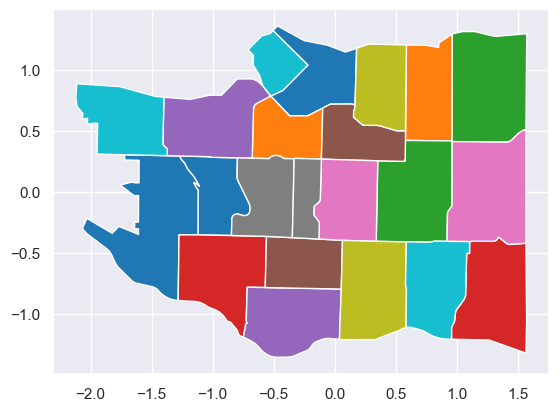

In [8]:
#neighborhood zones

neighbourhood = gpd.read_file('data/local-area-boundary.zip')

# Rename column for clarity
neighbourhood = neighbourhood.rename(columns={'name':'neighbourhood'})

# Sort alphabetically
neighbourhood = neighbourhood.sort_values(by='neighbourhood').reset_index()

# Add population column to neighbourhood list
# neighbourhood['population'] = population['population']

# neighbourhood['geometry'] = norm(neighbourhood['geometry'], 2, 2.25, -200, 147.65)
# print(neighbourhood['geometry'])

# def scaling(poly, cen):
    # o = (x,y)
    # factor = 1/0.14
    # poly = affinity.scale(poly, xfact=factor, yfact=factor * 1.525, origin=cen)
    # poly = affinity.translate(poly, xoff=120.1, yoff=-46.65)
    # return poly

# scale = np.vectorize(scaling)
# polys = unary_union(neighbourhood['geometry'])
# centroid = polys.centroid
# # factor = (1/2**11)
# neighbourhood['geometry'] = scale(neighbourhood['geometry'], centroid)
    
#I used chatGPT for a better and more efficient way to normalize my polygons
#I added additional adjustments so that the maps would match up as the maps weren't identical in size
#which were neccesary to get as much accurate data as possible


def normalize_polygon2(polygon, translation, scaling_factor):
    # Translate
    tpoly = affinity.translate(polygon, xoff=-translation[0], yoff=-translation[1])
    # Scale
    return affinity.scale(tpoly, xfact=scaling_factor * 0.85, yfact=scaling_factor * 1.3, origin=(0, 0))

# Calculate the centroid of all polygons
all_polygons = unary_union(neighbourhood['geometry'])
common_centroid = (all_polygons.centroid.x, all_polygons.centroid.y)

# Calculate the average distance of the centroids of all polygons from the common centroid
avg_distance = neighbourhood['geometry'].apply(lambda x: x.centroid.distance(Point(common_centroid))).mean()

# Scaling factor to get an average distance of 1
scaling_factor = 1.0 / avg_distance

# Normalize all polygons
neighbourhood['geometry'] = neighbourhood['geometry'].apply(lambda x: normalize_polygon2(x, common_centroid, scaling_factor))

# Keep relevant columns
neighbourhood = neighbourhood[['neighbourhood', 'geometry']]

neighbourhood.plot(column='neighbourhood')

In [9]:
#neighborhood stats -> zone identification

def zone_identification(geo):
    for i in range(len(neighbourhood)):
        if neighbourhood.iloc[i]['geometry'].contains(geo):
            return neighbourhood.iloc[i]['neighbourhood']
    return "None"

# zone_identification("test")
z_id = np.vectorize(zone_identification)
transit_agg['zone'] = transit_agg['geometry'].apply(z_id)
# transit_agg['zone'] = transit_agg['geometry'].apply(lambda x: zone_identification(neighbourhood, x))
transit_agg

,geo_uid,geometry,quality_score,zone
0,59150307,"POLYGON ((1.547 1.185, 1.547 1.174, 1.547 1.16...",2.856574,Hastings-Sunrise
1,59150308,"POLYGON ((1.546 1.033, 1.546 1.021, 1.545 1.00...",5.510685,Hastings-Sunrise
2,59150309,"POLYGON ((1.455 1.034, 1.455 1.021, 1.455 1.00...",5.891830,Hastings-Sunrise
3,59150310,"POLYGON ((1.544 0.907, 1.544 0.894, 1.544 0.88...",6.565582,Hastings-Sunrise
4,59150311,"POLYGON ((1.454 0.881, 1.502 0.881, 1.502 0.86...",6.069549,Hastings-Sunrise
...,...,...,...,...
987,59153996,"POLYGON ((-0.259 1.135, -0.259 1.134, -0.261 1...",8.442239,Downtown
988,59153997,"POLYGON ((-0.119 1.128, -0.137 1.110, -0.144 1...",8.459761,Downtown
989,59154000,"POLYGON ((0.105 0.796, 0.105 0.792, 0.105 0.78...",7.863696,None
990,59154001,"POLYGON ((0.006 0.906, 0.031 0.900, 0.042 0.89...",8.882093,Downtown
